# Generate Search Summary
This notebook retrieves different subsets of the search and dumps them into a spreadsheet

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.store.mongo import MoleculePropertyDB
from moldesign.store.models import MoleculeData
from moldesign.store.recipes import redox_recipes
from rdkit.Chem import Descriptors
from rdkit import Chem
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import json
import yaml

RDKit WARNING: [11:37:14] Enabling RDKit 2019.09.3 jupyter extensions
[11:37:14] Enabling RDKit 2019.09.3 jupyter extensions


Define the search parameters

In [2]:
subset = 'ZINC15'  # Allowed source of the molecules
neutral = True  # Whether to get only charge-balanced molecules

Gather which properties to look up.

In [3]:
levels = [level.name for level in redox_recipes] 
solvation_energy = {'small': 'data.small_basis.neutral.solvation_energy.neutral.acetntrl.small_basis',
                    'normal': 'data.small_basis.neutral.solvation_energy.neutral.acetntrl.normal_basis',
                    'diffuse': 'data.small_basis.neutral.solvation_energy.neutral.acetntrl.diffuse_basis'}

## Query the current state of the search from MongoDB
Gather only the molecules in the target subset and return the accires at all available levels

Query the database to get the desired results

In [4]:
mongo = MoleculePropertyDB.from_connection_info(port=27855)

In [5]:
hits = []
for hit in tqdm(mongo.collection.find({'subsets': {'$in': [subset]}})):
    hits.append(MoleculeData.parse_obj(hit))

5928it [00:01, 3444.87it/s]


In [6]:
results = []
for hit in tqdm(hits):
    # Get the basic information
    result = {'smiles': hit.identifier['smiles'],
              'inchi': hit.identifier['inchi'],
              'record': hit,
              'molwt': Descriptors.MolWt(hit.mol),
              'charge': Chem.GetFormalCharge(hit.mol),
             'n_atoms': hit.mol.GetNumHeavyAtoms()}
    
    # Store the reduction potentials
    for label, data in zip(['ip', 'ea'], [hit.oxidation_potential, hit.reduction_potential]):
        for level in levels:
            result.update({f'{label}_' + level: data.get(level)})
    
    # Get the solvation
    for label, key in solvation_energy.items():
        try:
            result[f'solv_eng_{label}'] = hit.get_data(key)
        except KeyError:
            continue
    
    results.append(result)
results = pd.DataFrame(results)

 32%|███▏      | 1894/5928 [00:01<00:02, 1627.21it/s]RDKit WARNING: [11:37:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:37:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:37:19] WARNING: not removing hydrogen atom without neighbors
[11:37:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:37:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:37:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:37:19] WARNING: not removing hydrogen atom without neighbors
 35%|███▍      | 2066/5928 [00:01<00:02, 1654.98it/s][11:37:19] WARNING: not removing hydrogen atom without neighbors
[11:37:19] WARNING: not removing hydrogen atom without neighbors
[11:37:19] WARNING: not removing hydrogen atom without neighbors
[11:37:19] WARNING: not removing hydrogen atom without neighbors
[11:37:19] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:37:19

Get only the nuetral molecules, if desired

In [7]:
if neutral:
    results.query('charge == 0', inplace=True)

Write out a subset of the data frame to illustrate its content

In [8]:
results.sort_values('ip_nob-acn-smb-geom', ascending=False)[['smiles', 'molwt', 'ip_nob-acn-smb-geom', 'solv_eng_normal']]

,smiles,molwt,ip_nob-acn-smb-geom,solv_eng_normal
34,CC(C)(C)C#N,83.134,12.293804,-0.009887
0,N#CC(F)(F)F,95.023,11.515871,-0.000564
366,CC(F)(F)F,84.040,11.181484,-0.003698
89,FC(F)(F)CC(F)(F)F,152.037,11.080289,-0.005729
2,C#CC(F)(F)F,94.035,10.962156,-0.002112
...,...,...,...,...
5923,O=C=Nc1nc(Cl)nc(N=C=O)n1,197.541,NaN,NaN
5924,Cn1nc([N+](=O)[O-])nc1N=[N+]=[N-],169.104,NaN,NaN
5925,CCc1cc(C(F)(F)F)cnc1C,189.180,NaN,NaN
5926,Cc1nc(C(C)C)no1,126.159,NaN,NaN


## Plot the Pareto Surface
What about our tradeoff betweeen solvation energy and EA

In [9]:
def get_dominating_solutions(results, redox_key = 'ea_dfb-acn-smb-geom', solv_key = 'solv_eng_diffuse', mols_to_skip = ()): 
    """Get the results with the best solvation energy for a certain redox potential
    
    Args:
        results: Results array to process
        redox_key: Name of the redox column
        solv_key: Name fo the solvation column
        mols_to_skip
    Returns:
        - Version of the results array with the pareto surface identified and distances from the surface collected
    """
    
    # Get a copy of the array
    results = results.copy()
    results = results[~results[[redox_key, solv_key]].isnull().any(axis=1)]
    
    # Remove all columns except those we are interested in
    results = results[['inchi', 'smiles', 'molwt', 'charge', redox_key, solv_key]]
    
    # Get rid of molecules in the skip list
    results = results[results.smiles.apply(lambda x: x not in mols_to_skip)]
    
    # Put a placeholder for whether something is on the surface
    #  and by how much it is off
    results['is_pareto'] = False
    results['redox_dist'] = 0
    results['solv_dist'] = 0

    # Get the dominating solutions
    pareto = []
    output = results
    results.sort_values(redox_key, inplace=True, ascending=redox_key.startswith('ea_'))
    while len(results) > 0:
        # Get the best value and remove it from the list
        new_best = results.iloc[0]
        
        # Mark the best as pareto optimal
        output.loc[results.index[0], 'is_pareto'] = True
        
        # Find all entries that also have a worse solvation
        dominated = results[solv_key] > new_best[solv_key]
        
        # Store the "dominated distance" 
        output.loc[results.index, 'redox_dist'] = np.abs(results[redox_key] - new_best[redox_key])
        output.loc[results.index, 'solv_dist'] = np.abs(new_best[solv_key] - results[solv_key])
        
        # Mark it as dominated
        results = results[~dominated]
        results = results.iloc[1:]
        
    # Sort by the distance to the dominating redox solution
    output.sort_values(['redox_dist', 'solv_dist'], ascending=True, inplace=True)
                          
    return output
pareto_front = get_dominating_solutions(results)

In [10]:
ea_results = get_dominating_solutions(results)

In [11]:
ea_results

,inchi,smiles,molwt,charge,ea_dfb-acn-smb-geom,solv_eng_diffuse,is_pareto,redox_dist,solv_dist
4798,"InChI=1S/C6H14O2/c1-5(3-7)6(2)4-8/h5-8H,3-4H2,...",C[C@H](CO)[C@@H](C)CO,118.176,0,-3.643512,-0.015743,True,0.000000,0.000000
3551,"InChI=1S/C7H14O2/c1-7(9)5-6(7)3-2-4-8/h6,8-9H,...",C[C@]1(O)C[C@@H]1CCCO,130.187,0,-2.387830,-0.018132,True,0.000000,0.000000
4543,"InChI=1S/C7H16O2/c1-6(8)4-3-5-7(2)9/h6-9H,3-5H...",C[C@H](O)CCC[C@H](C)O,132.203,0,-2.263675,-0.018401,True,0.000000,0.000000
3561,"InChI=1S/C7H14O2/c1-2-7(9)6-3-5(6)4-8/h5-9H,2-...",CC[C@H](O)[C@@H]1C[C@H]1CO,130.187,0,-2.094647,-0.019065,True,0.000000,0.000000
3434,"InChI=1S/C5H9F3O/c6-1-5(2-7,3-8)4-9/h9H,1-4H2",OCC(CF)(CF)CF,142.120,0,-1.962233,-0.023316,True,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
44,InChI=1S/C10H12O4/c1-5-7(11)10(14-4)6(2)8(12)9...,COC1=C(C)C(=O)C(OC)=C(C)C1=O,196.202,0,1.785156,-0.011742,False,5.428668,0.004000
42,InChI=1S/C4H2O2S/c5-3-1-2-4(6)7-3/h1-2H,O=C1C=CC(=O)S1,114.125,0,1.867747,-0.014431,False,5.511259,0.001311
43,InChI=1S/C7H6O3S/c1-11-7-3-5(9)4(8)2-6(7)10/h2...,CSC1=CC(=O)C(O)=CC1=O,170.189,0,2.191609,-0.015134,False,5.835121,0.000609
3730,"InChI=1S/C2H3F3N2O/c3-6-2(1-8)7(4)5/h8H,1H2/b6-2-",OC/C(=N/F)N(F)F,128.053,0,2.641660,-0.011326,False,6.285172,0.004416


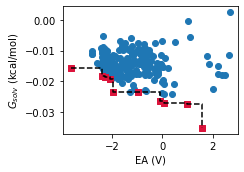

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

pareto_front = ea_results.query('is_pareto')
ax.scatter(ea_results['ea_dfb-acn-smb-geom'], ea_results['solv_eng_diffuse'])
ax.scatter(pareto_front['ea_dfb-acn-smb-geom'], pareto_front['solv_eng_diffuse'], s=35, marker='s', color='crimson')
ax.step(pareto_front['ea_dfb-acn-smb-geom'], pareto_front['solv_eng_diffuse'], 'k--', where='post')

ax.set_xlabel('EA (V)')
ax.set_ylabel('$G_{solv}$ (kcal/mol)')

fig.tight_layout()
fig.savefig('pthalimide-pareto.png', dpi=320)

In [13]:
pareto_front

,inchi,smiles,molwt,charge,ea_dfb-acn-smb-geom,solv_eng_diffuse,is_pareto,redox_dist,solv_dist
4798,"InChI=1S/C6H14O2/c1-5(3-7)6(2)4-8/h5-8H,3-4H2,...",C[C@H](CO)[C@@H](C)CO,118.176,0,-3.643512,-0.015743,True,0.0,0.0
3551,"InChI=1S/C7H14O2/c1-7(9)5-6(7)3-2-4-8/h6,8-9H,...",C[C@]1(O)C[C@@H]1CCCO,130.187,0,-2.387830,-0.018132,True,0.0,0.0
4543,"InChI=1S/C7H16O2/c1-6(8)4-3-5-7(2)9/h6-9H,3-5H...",C[C@H](O)CCC[C@H](C)O,132.203,0,-2.263675,-0.018401,True,0.0,0.0
3561,"InChI=1S/C7H14O2/c1-2-7(9)6-3-5(6)4-8/h5-9H,2-...",CC[C@H](O)[C@@H]1C[C@H]1CO,130.187,0,-2.094647,-0.019065,True,0.0,0.0
3434,"InChI=1S/C5H9F3O/c6-1-5(2-7,3-8)4-9/h9H,1-4H2",OCC(CF)(CF)CF,142.120,0,-1.962233,-0.023316,True,0.0,0.0
22,"InChI=1S/C3H4N2O/c6-3-1-4-2-5-3/h1-2,6H,(H,4,5)",Oc1cnc[nH]1,84.078,0,-0.982512,-0.023462,True,0.0,0.0
3711,InChI=1S/C9H10N2/c1-2-6-7(3-1)9-8(6)4-10-5-11-...,C1=CC2=C3NCNC[C@H]3C2=C1,146.193,0,-0.084015,-0.026371,True,0.0,0.0
4610,InChI=1S/C5H4N4S/c1-2-10-5(6-1)4-7-3-8-9-4/h1-...,c1csc(-c2nc[nH]n2)n1,152.182,0,0.055735,-0.027062,True,0.0,0.0
3458,"InChI=1S/C5H9N3S/c1-3(2)4-7-5(6)8-9-4/h3H,1-2H...",CC(C)c1nc(=N)[nH]s1,143.215,0,0.967804,-0.027264,True,0.0,0.0
3823,InChI=1S/C10H8N2O2/c11-6-3-1-2-5-7(12)4-8(13)1...,NC1=CC(=O)C(=O)c2c(N)cccc21,188.186,0,1.583383,-0.035097,True,0.0,0.0


In [14]:
ip_results = get_dominating_solutions(results, 'ip_nob-acn-smb-geom', 'solv_eng_normal')#, mols_to_skip=('F[N+](F)(F)F', 'N#Cc1oncc1C=O'))

In [15]:
ip_results

,inchi,smiles,molwt,charge,ip_nob-acn-smb-geom,solv_eng_normal,is_pareto,redox_dist,solv_dist
34,"InChI=1S/C5H9N/c1-5(2,3)4-6/h1-3H3",CC(C)(C)C#N,83.134,0,12.293804,-0.009887,True,0.000000,0.000000
3934,InChI=1S/C4HN3/c5-1-4(2-6)3-7/h4H,N#CC(C#N)C#N,91.073,0,9.474326,-0.015355,True,0.000000,0.000000
57,InChI=1S/C3H2N2/c4-2-1-3-5/h1H2,N#CCC#N,66.063,0,9.436076,-0.016292,True,0.000000,0.000000
3972,InChI=1S/C6H2N4/c7-1-5(2-8)6(3-9)4-10/h5-6H,N#CC(C#N)C(C#N)C#N,130.110,0,9.146472,-0.025387,True,0.000000,0.000000
2603,"InChI=1S/C9H8N4/c10-5-1-9(2-6-11,3-7-12)4-8-13...",N#CCC(CC#N)(CC#N)CC#N,172.191,0,9.019852,-0.033206,True,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
4316,"InChI=1S/C2F3N3S/c3-2(4,5)1-6-7-8-9-1",FC(F)(F)c1nnns1,155.104,0,6.104814,0.000583,False,6.188990,0.010470
69,InChI=1S/C11H16/c1-3-4-5-11-8-6-10(2)7-9-11/h6...,CCCCc1ccc(C)cc1,148.249,0,5.923453,-0.009858,False,6.370352,0.000029
65,"InChI=1S/C9H12/c1-7-4-5-8(2)9(3)6-7/h4-6H,1-3H3",Cc1ccc(C)c(C)c1,120.195,0,5.793578,-0.008659,False,6.500226,0.001228
44,InChI=1S/C10H12O4/c1-5-7(11)10(14-4)6(2)8(12)9...,COC1=C(C)C(=O)C(OC)=C(C)C1=O,196.202,0,5.745573,-0.009591,False,6.548231,0.000296


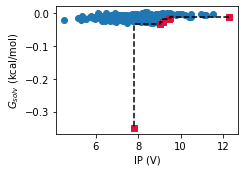

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

pareto_front = ip_results.query('is_pareto')
ax.scatter(ip_results['ip_nob-acn-smb-geom'], ip_results['solv_eng_normal'])
ax.scatter(pareto_front['ip_nob-acn-smb-geom'], pareto_front['solv_eng_normal'], s=35, marker='s', color='crimson')
ax.step(pareto_front['ip_nob-acn-smb-geom'], pareto_front['solv_eng_normal'], 'k--', where='post')

ax.set_xlabel('IP (V)')
ax.set_ylabel('$G_{solv}$ (kcal/mol)')

fig.tight_layout()

In [17]:
pareto_front

,inchi,smiles,molwt,charge,ip_nob-acn-smb-geom,solv_eng_normal,is_pareto,redox_dist,solv_dist
34,"InChI=1S/C5H9N/c1-5(2,3)4-6/h1-3H3",CC(C)(C)C#N,83.134,0,12.293804,-0.009887,True,0.0,0.0
3934,InChI=1S/C4HN3/c5-1-4(2-6)3-7/h4H,N#CC(C#N)C#N,91.073,0,9.474326,-0.015355,True,0.0,0.0
57,InChI=1S/C3H2N2/c4-2-1-3-5/h1H2,N#CCC#N,66.063,0,9.436076,-0.016292,True,0.0,0.0
3972,InChI=1S/C6H2N4/c7-1-5(2-8)6(3-9)4-10/h5-6H,N#CC(C#N)C(C#N)C#N,130.110,0,9.146472,-0.025387,True,0.0,0.0
2603,"InChI=1S/C9H8N4/c10-5-1-9(2-6-11,3-7-12)4-8-13...",N#CCC(CC#N)(CC#N)CC#N,172.191,0,9.019852,-0.033206,True,0.0,0.0
197,InChI=1S/C5H2N2O2/c6-1-5-4(3-8)2-7-9-5/h2-3H,N#Cc1oncc1C=O,122.083,0,7.809750,-0.350256,True,0.0,0.0


## Save them to disk
Let's make a memorable filename and dump accordingly

In [18]:
filename = datetime.now().strftime('%y%m%d')  # Start with the date

In [19]:
if neutral:   # Mark whether we only output the neutrals
    filename += "-neutral_only"

In [20]:
if subset:
    filename += f'-subset_{subset}'

In [21]:
print(f'Filename postfix: {filename}')

Filename postfix: 220525-neutral_only-subset_ZINC15


Save the data to a collection folder

In [22]:
output_folder = Path('results')
output_folder.mkdir(exist_ok=True)

In [23]:
ea_results.to_csv(output_folder / f'anolytes-{filename}.csv', index=False)

In [24]:
ip_results.to_csv(output_folder / f'catholytes-{filename}.csv', index=False)